In [1]:
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import mmh3
import os
import pickle
import math
def combinations(n, k):
    def backtrack(start, combo):
        if len(combo) == k:
            result.append(combo[:])
            return
        for i in range(start, n + 1):
            combo.append(i)
            backtrack(i + 1, combo)
            combo.pop()

    result = []
    backtrack(1, [])
    return result

def combination(n, k):
    if k == 0 or k == n:
        return 1
    else:
        return combination(n - 1, k - 1) + combination(n - 1, k)

In [2]:
class KSuperCube:
    
    def __init__(self, prob, t, k):
        self.prob = prob
        self.t = t
        self.k = k
        self.real_hash_table_table_dc = {}
        self.real_hash_table_table_dpc = {}
        self.real_hash_table_table_sc = {}
        self.pred_hash_table_table_dc = {}
        self.pred_hash_table_table_dpc = {}
        self.pred_hash_table_table_sc = {}
        self.total_spreads_dc = {}
        self.total_spreads_dpc = {}
        self.total_spreads_sc = {}
        for i in range(1, t + 1):
            self.real_hash_table_table_dc[i] = None
            self.real_hash_table_table_dpc[i] = None
            self.real_hash_table_table_sc[i] = None
            self.pred_hash_table_table_dc[i] = None
            self.pred_hash_table_table_dpc[i] = None
            self.pred_hash_table_table_sc[i] = None
        self.real_spreads_dc = defaultdict(int)
        self.real_spreads_dpc = defaultdict(int)
        self.real_spreads_sc = defaultdict(int)
        self.pred_spreads_dc = defaultdict(int)
        self.pred_spreads_dpc = defaultdict(int)
        self.pred_spreads_sc = defaultdict(int)
        self.are_dc = 0.0
        self.are_dpc = 0.0
        self.are_sc = 0.0
        self.count_dc = 0
        self.count_dpc = 0
        self.count_sc = 0
        self.range_are_dc = {}
        self.range_are_dpc = {}
        self.range_are_sc = {}
        self.range_count_dc = {}
        self.range_count_dpc = {}
        self.range_count_sc = {}
        for i in range(7):
            self.range_are_dc[i] = 0.0
            self.range_are_dpc[i] = 0.0
            self.range_are_sc[i] = 0.0
            self.range_count_dc[i] = 0
            self.range_count_dpc[i] = 0
            self.range_count_sc[i] = 0
    
    def init_data(self, dir_dc, dir_dpc, dir_sc, dir_est):
        for idx, real_file in enumerate(['00.pkl', '01.pkl', '02.pkl']):
            if real_file.find(".pkl") == -1:
                continue
            f = open(dir_dc + real_file, 'rb')
            print(dir_dc + real_file)
            hash_table = pickle.load(f)
            self.real_hash_table_table_dc[idx + 1] = hash_table
            f.close()
        print("[Message] DC real dataset has been loaded.")
        for idx, real_file in enumerate(['00.pkl', '01.pkl', '02.pkl']):
            if real_file.find(".pkl") == -1:
                continue
            f = open(dir_dpc + real_file, 'rb')
            print(dir_dpc + real_file)
            hash_table = pickle.load(f)
            self.real_hash_table_table_dpc[idx + 1] = hash_table
            f.close()
        print("[Message] DPC real dataset has been loaded.")
        for idx, real_file in enumerate(['00.pkl', '01.pkl', '02.pkl']):
            if real_file.find(".pkl") == -1:
                continue
            f = open(dir_sc + real_file, 'rb')
            print(dir_sc + real_file)
            hash_table = pickle.load(f)
            self.real_hash_table_table_sc[idx + 1] = hash_table
            f.close()
        print("[Message] SC real dataset has been loaded.")
        for idx, pred_file in enumerate(["00.pkl", '01.pkl', '02.pkl']):
            if pred_file.find(".pkl") == -1:
                continue
            f = open(dir_est + pred_file, 'rb')
            print(dir_est + pred_file)
            hash_table = pickle.load(f)
            self.pred_hash_table_table_dc[idx + 1] = hash_table
            self.pred_hash_table_table_dpc[idx + 1] = {}
            self.pred_hash_table_table_sc[idx + 1] = {}
            for key in tqdm(hash_table):
                self.pred_hash_table_table_dpc[idx + 1][key] = {}
                for dst in hash_table[key]:
                    if dst not in self.pred_hash_table_table_sc[idx + 1]:
                        self.pred_hash_table_table_sc[idx + 1][dst] = {key:self.pred_hash_table_table_dc[idx + 1][key][dst]}
                    else:
                        if key not in self.pred_hash_table_table_sc[idx + 1][dst]:
                            self.pred_hash_table_table_sc[idx + 1][dst][key] = self.pred_hash_table_table_dc[idx + 1][key][dst]
                    for port in hash_table[key][dst]:
                        if port not in self.pred_hash_table_table_dpc[idx + 1][key]:
                            self.pred_hash_table_table_dpc[idx + 1][key][port] = {dst}
                        else:
                            self.pred_hash_table_table_dpc[idx + 1][key][port].add(dst)
            f.close()
        print("[Message] Dataset has been initted.")
        for idx in tqdm(range(self.t)):
            table = self.real_hash_table_table_dc[idx + 1]
            for key in table:
                if key not in self.total_spreads_dc:
                    self.total_spreads_dc[key] = {}
                    for ele in table[key]:
                        self.total_spreads_dc[key][ele] = 1
                else:
                    for ele in table[key]:
                        if ele in self.total_spreads_dc[key]:
                            self.total_spreads_dc[key][ele] += 1
                        else:
                            self.total_spreads_dc[key][ele] = 1
        for key in tqdm(self.total_spreads_dc):
            count_ = 0
            for ele in self.total_spreads_dc[key]:
                if self.total_spreads_dc[key][ele] >= self.k:
                    count_ += 1
            self.real_spreads_dc[key] = count_
        print("[Message] DC real spreads have been finished.")
        for idx in tqdm(range(self.t)):
            table = self.real_hash_table_table_dpc[idx + 1]
            for key in table:
                if key not in self.total_spreads_dpc:
                    self.total_spreads_dpc[key] = {}
                    for ele in table[key]:
                        self.total_spreads_dpc[key][ele] = 1
                else:
                    for ele in table[key]:
                        if ele in self.total_spreads_dpc[key]:
                            self.total_spreads_dpc[key][ele] += 1
                        else:
                            self.total_spreads_dpc[key][ele] = 1
        for key in tqdm(self.total_spreads_dpc):
            count_ = 0
            for ele in self.total_spreads_dpc[key]:
                if self.total_spreads_dpc[key][ele] >= self.k:
                    count_ += 1
            self.real_spreads_dpc[key] = count_
        print("[Message] DPC real spreads have been finished.")
        for idx in tqdm(range(self.t)):
            table = self.real_hash_table_table_sc[idx + 1]
            for key in table:
                if key not in self.total_spreads_sc:
                    self.total_spreads_sc[key] = {}
                    for ele in table[key]:
                        self.total_spreads_sc[key][ele] = 1
                else:
                    for ele in table[key]:
                        if ele in self.total_spreads_sc[key]:
                            self.total_spreads_sc[key][ele] += 1
                        else:
                            self.total_spreads_sc[key][ele] = 1
        for key in tqdm(self.total_spreads_sc):
            count_ = 0
            for ele in self.total_spreads_sc[key]:
                if self.total_spreads_sc[key][ele] >= self.k:
                    count_ += 1
            self.real_spreads_sc[key] = count_
        print("[Message] SC real spreads have been finished.")
    
    def estimate_dc(self, key):
        est = 0
        nfjt = {}
        for j in range(self.t, self.k - 1, -1):
            sum_j = 0
            solutions = combinations(self.t, j)
            for sol in solutions:
                Nfj = None
                for kk in range(j):
                    if kk == 0:
                        if key in self.pred_hash_table_table_dc[sol[kk]]:
                            Nfj = set(self.pred_hash_table_table_dc[sol[kk]][key].keys()).copy()
                        else:
                            Nfj = set([])
                    else:
                        if key in self.pred_hash_table_table_dc[sol[kk]]:
                            Nfj = Nfj.intersection(set(self.pred_hash_table_table_dc[sol[kk]][key].keys()))
                        else:
                            Nfj = set([])
                for ke in list(Nfj):
                    prod_p = 1
                    for s in sol:
                        v = self.pred_hash_table_table_dc[s][key][ke]
                        prod_p *= 1 - (1 - self.prob) ** len(v) if len(v) < math.ceil(1 / self.prob) else 1 - (1 - self.prob) ** (len(v) / self.prob)
                    sum_j += 1 / prod_p
            if j == self.t:
                nfjt[j] = sum_j
            else:
                temp_sum = 0
                for l in range(j + 1, self.t + 1):
                    temp_sum += combination(l, j) * nfjt[l]
                nfjt[j] = sum_j - temp_sum
        for l in range(self.k, self.t + 1):
            est += nfjt[l]
        return max(est,1)
    
    def estimate_dpc(self, key):
        est = 0
        nfjt = {}
        for j in range(self.t, self.k - 1, -1):
            sum_j = 0
            solutions = combinations(self.t, j)
            for sol in solutions:
                Nfj = None
                for kk in range(j):
                    if kk == 0:
                        if key in self.pred_hash_table_table_dpc[sol[kk]]:
                            Nfj = set(self.pred_hash_table_table_dpc[sol[kk]][key].keys()).copy()
                        else:
                            Nfj = set([])
                    else:
                        if key in self.pred_hash_table_table_dpc[sol[kk]]:
                            Nfj = Nfj.intersection(set(self.pred_hash_table_table_dpc[sol[kk]][key].keys()))
                        else:
                            Nfj = set([])
                for ke in list(Nfj):
                    prod_p = 1
                    for s in sol:
                        v = self.pred_hash_table_table_dpc[s][key][ke]
                        prod_p *= 1 - (1 - self.prob) ** len(v) if len(v) < math.ceil(1 / self.prob) else 1 - (1 - self.prob) ** (len(v) / self.prob)
                    sum_j += 1 / prod_p
            if j == self.t:
                nfjt[j] = sum_j
            else:
                temp_sum = 0
                for l in range(j + 1, self.t + 1):
                    temp_sum += combination(l, j) * nfjt[l]
                nfjt[j] = sum_j - temp_sum
        for l in range(self.k, self.t + 1):
            est += nfjt[l]
        return max(est,1)
    
    def estimate_sc(self, key):
        est = 0
        nfjt = {}
        for j in range(self.t, self.k - 1, -1):
            sum_j = 0
            solutions = combinations(self.t, j)
            for sol in solutions:
                Nfj = None
                for kk in range(j):
                    if kk == 0:
                        if key in self.pred_hash_table_table_sc[sol[kk]]:
                            Nfj = set(self.pred_hash_table_table_sc[sol[kk]][key].keys()).copy()
                        else:
                            Nfj = set([])
                    else:
                        if key in self.pred_hash_table_table_sc[sol[kk]]:
                            Nfj = Nfj.intersection(set(self.pred_hash_table_table_sc[sol[kk]][key].keys()))
                        else:
                            Nfj = set([])
                for ke in list(Nfj):
                    prod_p = 1
                    for s in sol:
                        v = self.pred_hash_table_table_sc[s][key][ke]
                        prod_p *= 1 - (1 - self.prob) ** len(v) if len(v) < math.ceil(1 / self.prob) else 1 - (1 - self.prob) ** (len(v) / self.prob)
                    sum_j += 1 / prod_p
            if j == self.t:
                nfjt[j] = sum_j
            else:
                temp_sum = 0
                for l in range(j + 1, self.t + 1):
                    temp_sum += combination(l, j) * nfjt[l]
                nfjt[j] = sum_j - temp_sum
        for l in range(self.k, self.t + 1):
            est += nfjt[l]
        return max(est,1)
    
    def run(self):
        for key in tqdm(self.real_spreads_dc):
            real_dc = self.real_spreads_dc[key]
            if real_dc != 0:
                pred_dc = self.estimate_dc(key)
                range_dc_ = int(np.log10(real_dc)) if real_dc != 0 else 0
                self.range_count_dc[range_dc_] += 1            
                self.range_are_dc[range_dc_] += abs(real_dc - pred_dc) / real_dc if real_dc != 0 else 0
                self.pred_spreads_dc[key] = pred_dc
                self.count_dc += 1
                self.are_dc += abs(real_dc - pred_dc) / real_dc if real_dc != 0 else 0
            real_dpc = self.real_spreads_dpc[key]
            if real_dpc != 0:
                pred_dpc = self.estimate_dpc(key)
                range_dpc_ = int(np.log10(real_dpc)) if real_dpc != 0 else 0
                self.range_count_dpc[range_dpc_] += 1
                self.range_are_dpc[range_dpc_] += abs(real_dpc - pred_dpc) / real_dpc if real_dpc != 0 else 0
                self.pred_spreads_dpc[key] = pred_dpc
                self.count_dpc += 1
                self.are_dpc += abs(real_dpc - pred_dpc) / real_dpc if real_dpc != 0 else 0
        for key in tqdm(self.real_spreads_sc):
            real_sc = self.real_spreads_sc[key]
            if real_sc != 0:
                pred_sc = self.estimate_sc(key)
                range_sc_ = int(np.log10(real_sc)) if real_sc != 0 else 0
                self.range_count_sc[range_sc_] += 1
                self.range_are_sc[range_sc_] += abs(real_sc - pred_sc) / real_sc if real_sc != 0 else 0
                self.count_sc += 1
                self.are_sc += abs(real_sc - pred_sc) / real_sc if real_sc != 0 else 0
                self.pred_spreads_sc[key] = pred_sc
        print("[Message] K-dc, K-dpc and K-sc persistent spreads estimation has been finished.")
        for idx in self.range_are_dc:
            self.range_are_dc[idx] = self.range_are_dc[idx] / self.range_count_dc[idx] if self.range_count_dc[idx] != 0 else 0
            self.range_are_dpc[idx] = self.range_are_dpc[idx] / self.range_count_dpc[idx] if self.range_count_dpc[idx] != 0 else 0
            self.range_are_sc[idx] = self.range_are_sc[idx] / self.range_count_sc[idx] if self.range_count_sc[idx] != 0 else 0
        self.are_dc = self.are_dc / self.count_dc
        self.are_dpc = self.are_dpc / self.count_dpc
        self.are_sc = self.are_sc / self.count_sc
    
    def draw_dc(self):
        x = np.arange(0, 7, 1)
        x_log = []
        y_log = []
        for key in tqdm(self.pred_spreads_dc):
            x_log.append(self.real_spreads_dc[key])
            y_log.append(self.pred_spreads_dc[key])
        x_log = np.log10(x_log)
        y_log = np.log10(y_log)
        plt.plot(x, x, color = 'black')
        plt.plot(x_log, y_log, '*', color = 'black')
        plt.xlabel("Real Spreads")
        plt.ylabel("Estimated Spreads")
        plt.title("K persistent dc estimation")
        plt.show()
    
    def draw_dpc(self):
        x = np.arange(0, 7, 1)
        x_log = []
        y_log = []
        for key in tqdm(self.pred_spreads_dpc):
            x_log.append(self.real_spreads_dpc[key])
            y_log.append(self.pred_spreads_dpc[key])
        x_log = np.log10(x_log)
        y_log = np.log10(y_log)
        plt.plot(x, x, color = 'black')
        plt.plot(x_log, y_log, '*', color = 'black')
        plt.xlabel("Real Spreads")
        plt.ylabel("Estimated Spreads")
        plt.title("K persistent dpc estimation")
        plt.show()
    
    def draw_sc(self):
        x = np.arange(0, 7, 1)
        x_log = []
        y_log = []
        for key in tqdm(self.pred_spreads_sc):
            x_log.append(self.real_spreads_sc[key])
            y_log.append(self.pred_spreads_sc[key])
        x_log = np.log10(x_log)
        y_log = np.log10(y_log)
        plt.plot(x, x, color= 'black')
        plt.plot(x_log, y_log, '*', color = 'black')
        plt.xlabel("Real Spreads")
        plt.ylabel("Estimated Spreads")
        plt.title("K persistent sc estimation")
        plt.show()
    
    def show(self):
        print("DC measure:")
        print(self.are_dc)
        for i in range(7):
            print("$[10^{},10^{})$: {}".format(i, i + 1, self.range_are_dc[i]))
        print("DPC measure:")
        print(self.are_dpc)
        for i in range(7):
            print("$[10^{},10^{})$: {}".format(i, i + 1, self.range_are_dpc[i]))
        print("SC measure:")
        print(self.are_sc)
        for i in range(7):
            print("$[10^{},10^{})$: {}".format(i, i + 1, self.range_are_sc[i]))

In [3]:
p = 0.7
t = 3
k = 3
ksc = KSuperCube(p, t, k)

In [4]:
dir_dc = "./real_spreads_dc/"
dir_dpc = "./real_spreads_dpc/"
dir_sc = "./real_spreads_sc/"
dir_est = "./pred_spreads/"
ksc.init_data(dir_dc, dir_dpc, dir_sc, dir_est)

./real_spreads_dc/00.pkl
./real_spreads_dc/01.pkl
./real_spreads_dc/02.pkl
[Message] DC real dataset has been loaded.
./real_spreads_dpc/00.pkl
./real_spreads_dpc/01.pkl
./real_spreads_dpc/02.pkl
[Message] DPC real dataset has been loaded.
./real_spreads_sc/00.pkl
./real_spreads_sc/01.pkl
./real_spreads_sc/02.pkl
[Message] SC real dataset has been loaded.
./pred_spreads/00.pkl


100%|██████████| 259187/259187 [00:05<00:00, 49930.19it/s] 


./pred_spreads/01.pkl


100%|██████████| 261219/261219 [00:06<00:00, 39076.52it/s]


./pred_spreads/02.pkl


  0%|          | 0/3 [00:00<?, ?it/s]

[Message] Dataset has been initted.


  0%|          | 0/3 [00:00<?, ?it/s]

[Message] DC real spreads have been finished.


  0%|          | 0/3 [00:00<?, ?it/s]

[Message] DPC real spreads have been finished.


100%|██████████| 1265897/1265897 [00:02<00:00, 552499.58it/s]

[Message] SC real spreads have been finished.


In [5]:
ksc.run()

100%|██████████| 1265897/1265897 [00:02<00:00, 605385.26it/s]

[Message] K-dc, K-dpc and K-sc persistent spreads estimation has been finished.


100%|██████████| 53434/53434 [00:00<00:00, 1160195.47it/s]


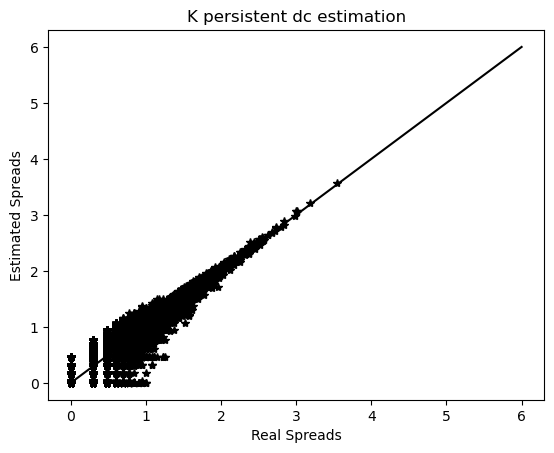

In [6]:
ksc.draw_dc()

100%|██████████| 66410/66410 [00:00<00:00, 1029314.14it/s]


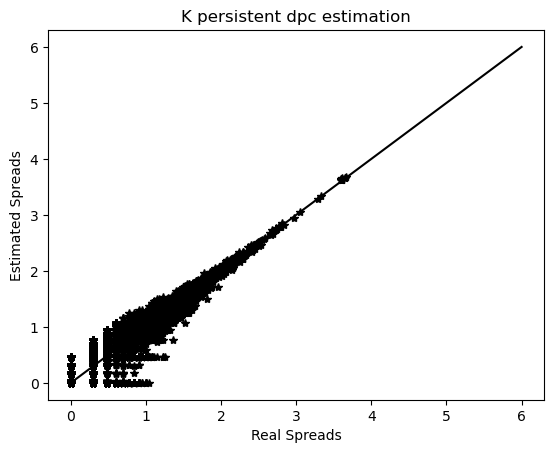

In [7]:
ksc.draw_dpc()

100%|██████████| 66915/66915 [00:00<00:00, 1126228.82it/s]


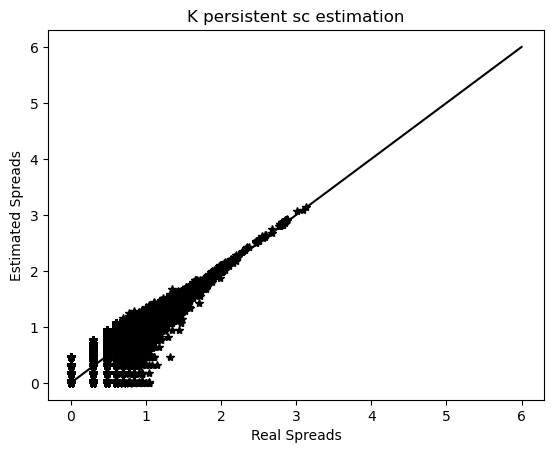

In [8]:
ksc.draw_sc()

In [9]:
ksc.show()

DC measure:
0.5674442737686433
$[10^0,10^1)$: 0.5900626622220935
$[10^1,10^2)$: 0.2074814823188168
$[10^2,10^3)$: 0.09619770325580866
$[10^3,10^4)$: 0.1133222731827435
$[10^4,10^5)$: 0
$[10^5,10^6)$: 0
$[10^6,10^7)$: 0
DPC measure:
0.5033417664722223
$[10^0,10^1)$: 0.5117752525642454
$[10^1,10^2)$: 0.2373821050865152
$[10^2,10^3)$: 0.08744240244905266
$[10^3,10^4)$: 0.04798028025230014
$[10^4,10^5)$: 0
$[10^5,10^6)$: 0
$[10^6,10^7)$: 0
SC measure:
0.5890485513053527
$[10^0,10^1)$: 0.5996664556984485
$[10^1,10^2)$: 0.25409631602192156
$[10^2,10^3)$: 0.10053666338197835
$[10^3,10^4)$: 0.04699729453502823
$[10^4,10^5)$: 0
$[10^5,10^6)$: 0
$[10^6,10^7)$: 0
